## Import packages

I import the following python packages:
- numpy: base for pandas
- pandas: to store the data in dataframes
- pandas_datareader: to import data
- statsmodels: for basic statistical models
- matplotlib: for plotting

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
import matplotlib.pyplot as plt
#import plotly.plotly as py
import datetime as dt

## Import data

This imports updated data directly from http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.
More specifically, I import market, size, value, and momentum factors, together with returns on 49 industry portfolios.

In [2]:
factors = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start='1/1/1900')[0]
mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='1/1/1900')[0]
factors = factors.join(mom)
factors = factors[['Mkt-RF','SMB','HML','Mom   ','RF']]

#factors /= 100

In [3]:
industries = web.DataReader("49_Industry_Portfolios_Daily", "famafrench", start='1/1/1900')[0]
industries[(industries <= -99.99) | (industries == -999)] = np.nan #set missing data to NaN

#industries /= 100

## Data description

This section serves to carry out basic sanity checks on the data to ensure everything has been imported correctly.

In [4]:
#factors.head()
factors.describe()

,Mkt-RF,SMB,HML,Mom,RF
count,24351.000000,24351.000000,24351.000000,24250.000000,24351.000000
mean,0.029150,0.005033,0.015844,0.026792,0.012433
std,1.062212,0.583658,0.583878,0.743895,0.011990
min,-17.440000,-11.620000,-5.980000,-18.330000,-0.003000
25%,-0.400000,-0.240000,-0.240000,-0.240000,0.001000
50%,0.060000,0.020000,0.010000,0.060000,0.010000
75%,0.490000,0.270000,0.260000,0.340000,0.020000
max,15.760000,8.210000,8.430000,7.010000,0.061000


In [5]:
#industries.head()
industries.describe()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,24351.000000,24351.000000,13931.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,...,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.000000,24351.00000,24351.000000,24351.000000
mean,0.042828,0.043164,0.054784,0.053809,0.052200,0.047024,0.053445,0.042896,0.040486,0.039822,...,0.047037,0.040092,0.038829,0.045576,0.047293,0.051506,0.044881,0.03609,0.046905,0.031698
std,1.490798,0.920302,1.374457,1.451575,1.193486,2.137007,1.795784,1.561825,1.157425,1.137699,...,1.250092,1.345007,1.650534,1.130896,1.330471,1.470677,1.364306,2.12843,1.567412,1.481672
min,-15.270000,-16.040000,-19.220000,-24.060000,-13.990000,-26.750000,-24.110000,-19.340000,-21.460000,-18.510000,...,-21.430000,-17.560000,-44.440000,-18.010000,-15.480000,-20.430000,-17.150000,-21.23000,-28.650000,-20.260000
25%,-0.640000,-0.350000,-0.615000,-0.560000,-0.470000,-0.850000,-0.720000,-0.640000,-0.470000,-0.450000,...,-0.560000,-0.560000,-0.540000,-0.440000,-0.600000,-0.500000,-0.530000,-0.79000,-0.540000,-0.620000
50%,0.010000,0.060000,0.040000,0.040000,0.040000,0.000000,0.040000,0.020000,0.040000,0.050000,...,0.050000,0.040000,0.050000,0.060000,0.060000,0.050000,0.040000,0.00000,0.050000,0.040000
75%,0.710000,0.450000,0.700000,0.660000,0.570000,0.900000,0.850000,0.700000,0.560000,0.550000,...,0.650000,0.650000,0.630000,0.540000,0.690000,0.600000,0.620000,0.80000,0.650000,0.690000
max,23.690000,15.540000,11.680000,19.910000,16.220000,39.740000,20.810000,33.400000,25.870000,20.490000,...,12.590000,18.490000,66.920000,17.810000,19.400000,23.050000,18.930000,36.78000,23.280000,16.840000


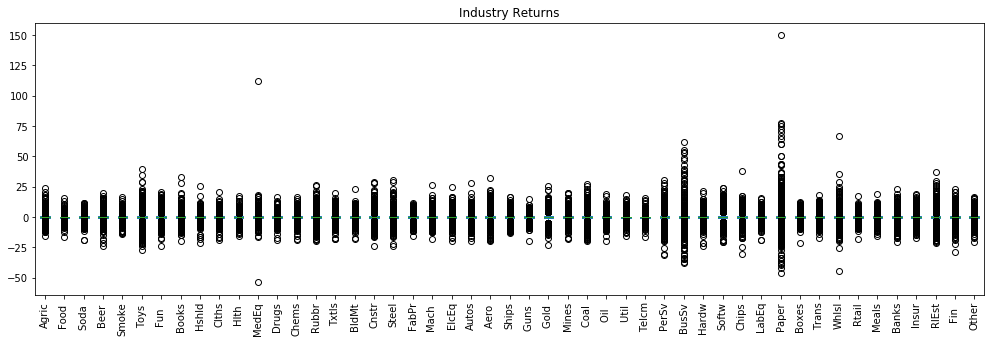

In [6]:
industries.plot.box(title='Industry Returns', figsize=(17,5), rot=90)
plt.show()

## Rolling window regressions

In this part I estimate rolling window betas and corresponding standard errors for each of the industry portfolios. The 'window' parameter defines the number of observations included in the rolling window.

\begin{equation*}
    \big(r^i_t - r^f_t\big) = \hat{\alpha^i} + \hat{\beta^i}*\big(r^M_t - r^f_t\big) + \varepsilon^i_t, \quad \quad \varepsilon^i_t \sim N(0,\sigma_i^2)
\end{equation*}

In [7]:
# number of months in beta estimation
window = 1

In [8]:
# get indexes for monthly calculation frequency
monthly = factors.iloc[:,0].resample('M').count()
stepIndex = monthly.cumsum()
obs = monthly.rolling(window, min_periods=1).sum().astype(int)

# set up ouput frames
β = pd.DataFrame(columns = industries.columns, index = monthly.index)
SE_β = pd.DataFrame(columns = industries.columns, index = monthly.index)
#rsquare = pd.DataFrame(columns = industries.columns, index = industries.index[window:])

for iMonth in range(window-1,len(monthly)):
    # select independent variables    
    lastObs = stepIndex.iat[iMonth]
    firstObs = lastObs-obs.iat[iMonth]
    X = sm.add_constant(factors.iloc[firstObs:lastObs, 0])
    
    for iAsset in range(0,len(industries.columns)):
        # select dependent variable
        y = industries.iloc[firstObs:lastObs, iAsset]
        
        # estimate model
        model = sm.OLS(y, X).fit()
        
        # store estimates
        β.iat[iMonth, iAsset] = model.params[1]
        SE_β.iat[iMonth, iAsset] = model.bse[1]
            #rsquare[iStep, iAsset] = model.rsquared
            
        # clear temporary variables
        del y, model
    del firstObs, lastObs, X

In [9]:
β.mean()

Agric    0.758062
Food     0.685542
Soda     0.792651
Beer     0.860198
Smoke    0.691325
Toys     1.160112
Fun      1.195512
Books    0.889557
Hshld    0.847141
Clths    0.740607
Hlth     1.042379
MedEq    0.825553
Drugs    0.863652
Chems    1.031955
Rubbr    0.800719
Txtls    0.843531
BldMt    0.979221
Cnstr    1.244590
Steel    1.284833
FabPr    0.961439
Mach     1.082158
ElcEq    1.244247
Autos    1.274335
Aero     1.226882
Ships    1.011705
Guns     0.839233
Gold     0.268465
Mines    0.917306
Coal     1.052215
Oil      0.982951
Util     0.636547
Telcm    0.713413
PerSv    0.855681
BusSv    0.831981
Hardw    1.140261
Softw    1.461531
Chips    1.232180
LabEq    1.054863
Paper    0.965389
Boxes    0.961209
Trans    1.121812
Whlsl    0.895045
Rtail    0.906785
Meals    0.883107
Banks    0.890081
Insur    0.801282
RlEst    0.928504
Fin      1.099295
Other    0.874488
dtype: float64

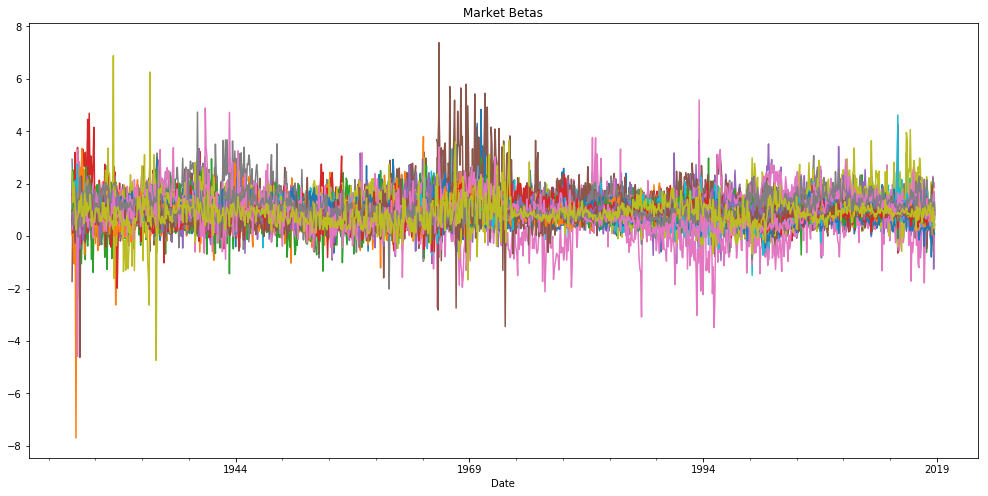

In [10]:
β.plot(title='Market Betas', figsize=(17,8), legend=False)
plt.show()

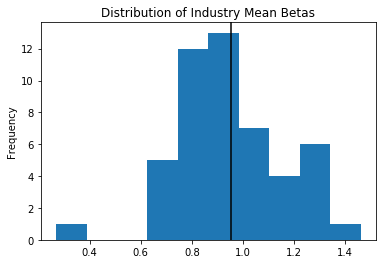

In [11]:
β.mean().plot.hist(title='Distribution of Industry Mean Betas')
plt.axvline(β.stack().mean(), color = 'k')
plt.show()

# Markov switching models

For each asset, I model the beta standard error as a constant intercept, but with the intercept switching between two different regimes. More formally:

\begin{equation*}
    \hat{\beta^i}_t = \mu_{S_t} + \varepsilon_{S_t},  \quad\quad   \varepsilon_{S_t} \sim N(0,\sigma_{S_t}^2)
\end{equation*}

where  $S_t \in \{0,1\}$ , and the regime switches according to the following transition matrix:

\begin{equation*}
    P(S_t = s_t \, | \, S_{t-1} = s_{t-1}) = 
    \begin{bmatrix}
        p_{00}& p_{10}\\
        1-p_{00} & 1-p_{10}\\
    \end{bmatrix}
\end{equation*}

The parameters $p_{00}, p_{10}, μ_0, μ_1, σ_0^2, σ_1^2$ are estimated by maximum likelihood.

In [12]:
ambig_β = pd.DataFrame(columns = industries.columns, index = β.index[window:])

for iAsset in range(0,len(industries.columns)):
    # extract data
    x = β.iloc[:,iAsset].astype(float)
    
    # estimate model
    model = sm.tsa.MarkovRegression(x, k_regimes=2, switching_variance=True).fit()
    
    # save estimates
    ambig_β.iloc[:,iAsset] = model.smoothed_marginal_probabilities[1]
    
    # clear temporary variables
    del x, model

C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:120: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_regression.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(-0.5 * resid**2 / variance) / np.sqrt(2 * np.pi * variance))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: in

In [13]:
#model.summary()

#fig, axes = plt.subplots(2, figsize=(17,6))
#ax = axes[0]
#ax.plot(model.smoothed_marginal_probabilities[0])
#ax.set(title='Probability of being in the low ambiguity regime')
#ax = axes[1]
#ax.plot(model.smoothed_marginal_probabilities[1])
#ax.set(title='Probability of being in the high ambiguity regime')
#fig.tight_layout()

The estimated models give us the probabilites of each asset independently being in the high ambiguity regime.

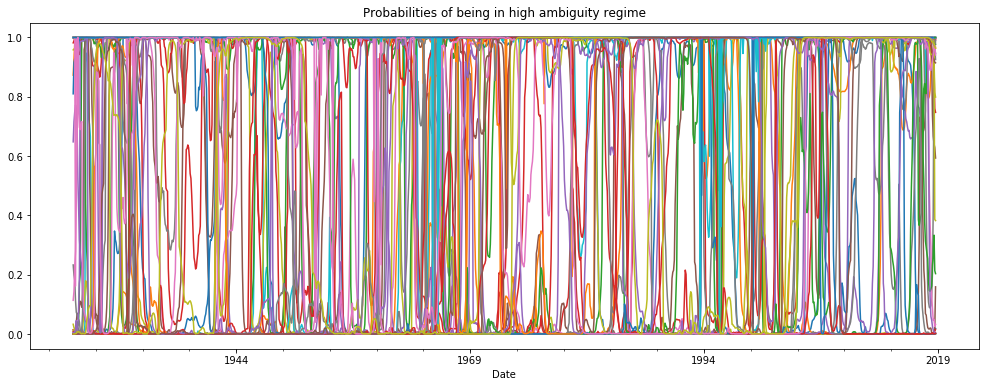

In [14]:
ambig_β.plot(title='Probabilities of being in high ambiguity regime', figsize=(17,6), legend=False)
plt.show()

In [15]:
ambig_β.describe()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,1107.000000,1107.000000,0.0,1107.000000,1107.000000,1107.000000,2.0,1107.000000,1.107000e+03,1.107000e+03,...,1107.000000,1107.000000,0.0,2.0,1.107000e+03,1107.000000,1.107000e+03,1107.000000,0.0,1.107000e+03
mean,0.625826,0.312645,NaN,0.363654,0.532854,0.300043,1.0,0.527183,4.376627e-01,5.901518e-01,...,0.993635,0.998647,NaN,1.0,2.744591e-01,0.497025,4.727680e-01,0.545898,NaN,4.767160e-01
std,0.449830,0.429992,NaN,0.449612,0.473304,0.423931,0.0,0.455373,4.868805e-01,4.701998e-01,...,0.071401,0.033115,NaN,0.0,4.154311e-01,0.465485,4.835224e-01,0.463224,NaN,4.687418e-01
min,0.000228,0.000242,NaN,0.000023,0.000116,0.000266,1.0,0.000361,1.800209e-07,3.619492e-07,...,0.000103,0.035027,NaN,1.0,5.556712e-07,0.000003,6.344691e-25,0.000229,NaN,6.170659e-32
25%,0.016158,0.000644,NaN,0.000224,0.000620,0.000775,1.0,0.001667,1.048441e-05,6.311266e-04,...,0.999998,1.000000,NaN,1.0,1.307317e-04,0.001935,2.751618e-04,0.001971,NaN,2.047607e-03
50%,0.961531,0.006985,NaN,0.038809,0.751753,0.004185,1.0,0.666097,4.107946e-03,9.846260e-01,...,1.000000,1.000000,NaN,1.0,1.361659e-03,0.464564,1.330152e-01,0.771535,NaN,2.857911e-01
75%,0.998115,0.890532,NaN,0.995199,0.999682,0.797252,1.0,0.997380,9.999604e-01,9.999062e-01,...,1.000000,1.000000,NaN,1.0,6.664515e-01,0.997201,9.993957e-01,0.999175,NaN,9.992591e-01
max,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.0,1.000000,1.000000e+00,1.000000e+00,...,1.000000,1.000000,NaN,1.0,9.999998e-01,1.000000,9.998868e-01,1.000000,NaN,9.998607e-01


## Analysis of predictive relation

Examining the predictive power of the ambiguity regimes.

In [16]:
strategy = (ambig_β.iloc[1:len(ambig_β)-1,:].round()*industries.iloc[2:,:])
strategy.index = industries.index[2:]

ValueError: Length mismatch: Expected axis has 24647 elements, new values have 24349 elements

In [ ]:
ind_index = (1 + industries).cumprod()
strat_index = (1 + strategy).cumprod()
#strat_index[0] = 1 # Set first value to 1

In [ ]:
strat_index.plot(title='', figsize=(17,6), legend=False)
plt.show()

In [ ]:
strats = strat_index.mean(axis=1)
inds = ind_index.mean(axis=1)
strats.plot(title='', figsize=(17,6), legend=False)
#inds.plot()
plt.show()

## Testing